# PARTIE 3 : Modèle DBScan

## Import librairies

In [553]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import plotly.express as px

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans, DBSCAN 
from sklearn.metrics import silhouette_score

import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

## Import des données

In [554]:
uber_ml = pd.read_csv('./src/full_dataset_for_ml.csv')
uber_ml.shape

(300000, 10)

## Recherche des clusters par heure pour un jour donné

Nous utilisons l'algorithme DBScan pour trouver les clusters.

Le jeudi (dayofweek=3) est le jour le plus représenté dans notre jeu de données. 

Dans cette partie nous nous intéressons aux données pour ce jour en particulier.

In [555]:
uber_ml.head()

Lat      Lon                 date     timestamp  year  month  day  \
0  40.7055 -74.0180  2014-08-10 14:01:00  1.407672e+09  2014      8   10   
1  40.7384 -73.9834  2014-04-26 02:12:00  1.398471e+09  2014      4   26   
2  40.7441 -73.9877  2014-04-13 23:22:00  1.397424e+09  2014      4   13   
3  40.7644 -73.9708  2014-09-27 13:38:00  1.411818e+09  2014      9   27   
4  40.7639 -73.9736  2014-08-08 19:09:00  1.407518e+09  2014      8    8   

   hour  minute  dayofweek  
0    14       1          6  
1     2      12          5  
2    23      22          6  
3    13      38          5  
4    19       9          4

In [556]:
columns_to_drop = ['date', 'timestamp', 'year', 'month', 'day', 'minute', 'dayofweek']
uber_ml_thursday = uber_ml[uber_ml['dayofweek']==3].drop(columns_to_drop, axis=1)
uber_ml_thursday.head()

Lat      Lon  hour
5   40.7692 -73.9829     7
6   40.7391 -74.0082     9
10  40.7199 -74.0001     8
13  40.7710 -73.8658    10
15  40.7588 -73.9775    21

In [557]:
hours = uber_ml_thursday['hour'].unique()
np.sort(hours)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23])

## Paramètres epsilon et min_samples

Nous recherchons la valeur optimale de epsilon et de min_samples (le nombre minimum de point dans un cluster).

Pour ce faire nous utilisons la techniques des plus proches voisins.

## Voisins les plus proches et distances

In [558]:
from sklearn.neighbors import NearestNeighbors
neighbors = NearestNeighbors(n_neighbors=4)
neighbors_fit = neighbors.fit(uber_ml_thursday)
distances, indices = neighbors_fit.kneighbors(uber_ml_thursday)

In [559]:
distances = np.sort(distances, axis=0)
len(distances)

49822

La courbe ci-dessous nous suggère une valeur optimale de epsilon de 0.25.

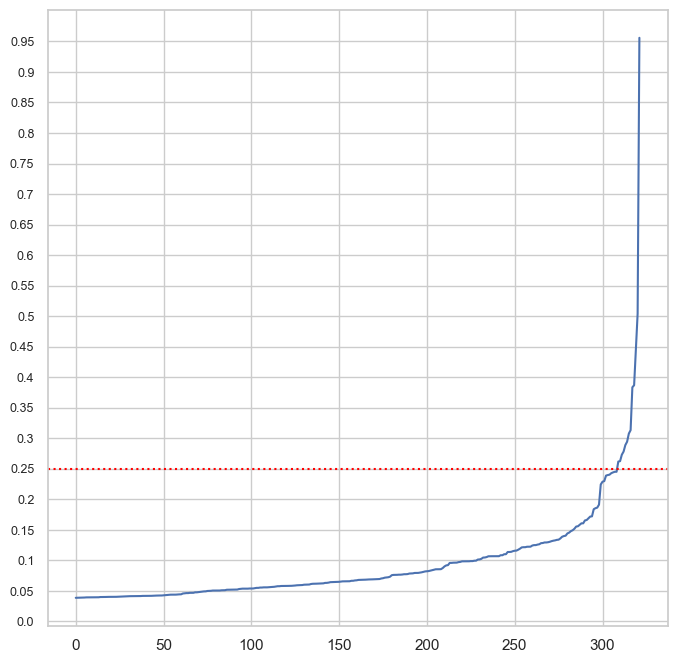

In [560]:
sns.set(rc={'figure.figsize':(8, 8)}, style='whitegrid')
sns.lineplot(data=distances[49500:,1])
plt.axhline(0.25, color='red', linestyle='dotted')
plt.yticks([i/100 for i in range(0,100,5)], [i/100 for i in range(0,100,5)], fontsize=9)
plt.show()

## Fonction find_clusters()

Nous créons une fonction qui entraîne un modèle DBScan et retourne les prédictions de clusters pour chaque heure de la journée.

In [561]:
predictions = []
clusters = []
silhouette_scores = []

def find_clusters(df, hour):

    df = df[df['hour'] == hour]
    df = df.drop(['hour'], axis=1)

    preprocessor = StandardScaler()
    X = preprocessor.fit_transform(df)

    dbs = DBSCAN(eps=0.25, min_samples=8, metric='manhattan')
    dbs.fit(X)
    df.loc[:, 'Cluster_DBScan'] = dbs.labels_
    scores = silhouette_score(X, dbs.labels_)
    nb_clusters = np.unique(dbs.labels_, return_counts=True)

    predictions.append(df)
    clusters.append(nb_clusters)
    silhouette_scores.append(scores)

## Application de la fonction

In [562]:
for i in range(0, 24):
    find_clusters(uber_ml_thursday, hour=i)

## Silhouette scores

- Un silhouette score élevé et proche de 1 indique que les clusters sont bien définis et bien délimités. 

- Un silhouette score proche de zéro indique que les clusters et leurs frontières sont moins bien définis (proches les uns des autres).

- Un silhouette score négatif indique que les clusters sont mal définis et que certains points pourraient appartenir à un autre cluster.

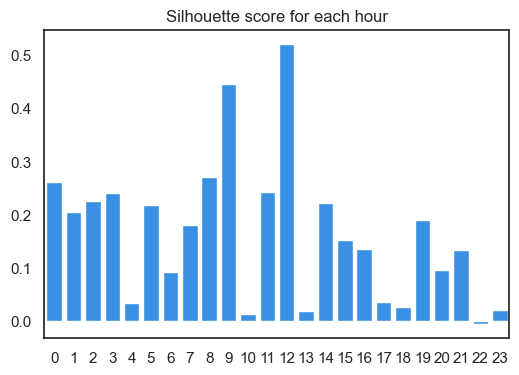

In [563]:
sns.set(rc={'figure.figsize':(6, 4)}, style='white')
sns.barplot(x=range(0,24), y=silhouette_scores, color='dodgerblue', width=.8)
plt.title('Silhouette score for each hour')
plt.yticks([i / 10 for i in range(0,6,1)], [i / 10 for i in range(0,6,1)])
plt.show() 

### Résultats : 

- Le silhouette score n'est pas uniforme suivant les heures de la journée.

- Il est le meilleur à 9h et à 23h. Cela signifie que les clusters sont bien délimités à ces horaires là.

- Il est le plus mauvais à 10h et à 13h. Cela signifie que les clusters sont moins bien définis à ces horaires là.

## Nombre de clusters trouvés

L'algorithme DBScan a trouvé entre 3 et 11 clusters dépendamment des heures de la journée.

In [564]:
cluters_count = []

for i in range(0,24):
    cluters_count.append(len(clusters[i][0]))

print('Min number of clusters:', min(cluters_count))
print('Max number of clusters:', max(cluters_count))


Min number of clusters: 3
Max number of clusters: 11


## Rassembler toutes les prédictions dans un dataframe

In [565]:
for i in range(24):
    predictions[i]['Hour'] = i

In [566]:
all_predictions = pd.DataFrame(columns=['Lat', 'Lon', 'Cluster_KMeans', 'Hour'])
all_predictions = pd.concat([predictions[i] for i in range(24)])
all_predictions = all_predictions.reset_index(drop=True)

In [567]:
all_predictions.tail()

Lat      Lon  Cluster_DBScan  Hour
49817  40.7363 -74.0082               0    23
49818  40.7438 -73.8559              -1    23
49819  40.7405 -74.0077               0    23
49820  40.7540 -73.9822               0    23
49821  40.7740 -73.8731               4    23

## Visualisation sur carte

### Zones dynamiques (hot zones)

In [568]:
import plotly.graph_objects as go

fig = go.Figure()

fig = px.scatter_mapbox(all_predictions[all_predictions['Cluster_DBScan'] != -1], 
                        lat = 'Lat', 
                        lon = 'Lon',
                        color = "Cluster_DBScan",
                        color_continuous_scale=px.colors.sequential.Plasma,
                        animation_frame = "Hour",
                        animation_group = "Hour",
                        mapbox_style = "carto-positron",
                        zoom = 9.5,
                        opacity = 1)

fig.update_layout(
        title = go.layout.Title(text = "Hot zones per hour on Thursday", x = 0.5),
        showlegend = True,
        height = 600)

fig.show()

## Généralisation

Nous généralisation l'application de l'algorithme à tous les jours de la semaine.

In [569]:
uber_ml = pd.read_csv('./src/full_dataset_for_ml.csv')

In [570]:
columns_to_drop = ['date', 'timestamp', 'year', 'month', 'day', 'minute']
uber_ml.drop(columns_to_drop, axis=1, inplace=True)

In [571]:
data_per_day = []
for i in range(0,7):
    one_day = uber_ml[uber_ml['dayofweek']==i].drop(['dayofweek'], axis=1).reset_index(drop=True)
    data_per_day.append(one_day)

In [572]:
clusters_per_day = []

for df in data_per_day:
    predictions = []
    for i in range(0, 24):
        find_clusters(df, hour=i)
    clusters_per_day.append(predictions)

In [573]:
for d in range(7):
    for h in range(24):
        clusters_per_day[d][h]['Hour'] = h
        clusters_per_day[d][h]['Day'] = d

In [574]:
all_predictions = []
for d in range(7):
    for h in range(24):
        all_predictions.append(clusters_per_day[d][h])

all_predictions = pd.concat(all_predictions)
all_predictions = all_predictions.reset_index(drop=True)

In [575]:
display(all_predictions)

Lat      Lon  Cluster_DBScan  Hour  Day
0       40.7140 -73.9899               0     0    0
1       40.8483 -73.9343              -1     0    0
2       40.6652 -73.9509              -1     0    0
3       40.7232 -73.9768               0     0    0
4       40.7414 -73.9950               0     0    0
...         ...      ...             ...   ...  ...
299995  40.7176 -74.0366               0    23    6
299996  40.8180 -73.9461               4    23    6
299997  40.5888 -73.9603              -1    23    6
299998  40.7708 -73.8657               5    23    6
299999  40.6638 -73.9530               0    23    6

[300000 rows x 5 columns]

## Visualisation

Nous affichons les zones dynamiques entre 12h et 13h par jour de la semaine.

In [576]:
import plotly.graph_objects as go

fig = go.Figure()

fig = px.scatter_mapbox(all_predictions[(all_predictions['Cluster_DBScan'] != -1) & (all_predictions['Hour']==12)], 
                        lat = 'Lat', 
                        lon = 'Lon',
                        color = "Cluster_DBScan",
                        color_continuous_scale=px.colors.sequential.Plasma,
                        animation_frame = "Day",
                        animation_group = "Day",
                        mapbox_style = "carto-positron",
                        zoom = 10,
                        opacity = 1)

fig.update_layout(
        title = go.layout.Title(text = "Hot zones at 12PM", x = 0.5),
        showlegend = True,
        height = 600)

fig.show()

# PARTIE 4 - Comparaison et conclusion

### Résultats : 

- Les algorithmes KMeans et DBScan nous ont permis de mettre en évidence les zones dynamiques à New York par jour et par heure de la journée.

- KMeans a mis en évidence 5 clusters. 

- DBScan a trouvé entre 3 et 11 clusters dépendamment de l'horaire.

- Les clusters obtenus sont très différents d'un algorithme à l'autre, en termes de taille, de forme et de localisation.

### Comparaison :

- Visuellement, les clusters obtenus avec DBScan sont plus étendus et éparpillés.  
--> Ils ne permettent pas de délimiter précisément des zones à cibler, notamment sur l'île de Manhattan qui est considérée comme un cluster à elle seule.

- Les clusters obtenus avec KMeans sont plus ciblés et nettement découpés.

- KMeans permet d'avoir les centroïdes des clusters, il n'y a pas de centroïdes avec DBScan.

### Conclusion : 

- KMeans est l'algorithme le plus pertinent pour répondre au besoin d'Uber.

- Il permet de mieux guider les taxis avec un découpage net et précis des zones dynamiques.

- Grâce aux centroïdes des clusters, nous pouvons proposer aux taxis un point précis et un périmètre à cibler.
